<a href="https://colab.research.google.com/github/Doppler-67/patisserie-customer-churn-forecasting/blob/main/patissiere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель проекта:**

Разработка ML модели для прогнозирования оттока клиентов.

Отдел маркетинга крупной сети кондитерских планирует промо акцию для удержания клиентов. Акция заключается в предоставлении скидки в 25 % тем клиентам, которые с высокой вероятностью перейдут к конкурентам.

**Описание данных:**

Для прогнозирования используются данные о покупках юзеров за период 2021 года. Всего доступно больше 2 млн. строк. Флаг оттока проставляется, если после покупки юзера прошло больше 45 дней. Поведение юзера описывается историей его покупок, суммой чека и размером скидки к чеку. В компании действует программа лояльности, участвуя в которой юзеры получают скидку на любую покупку и могут получать дополнительные скидки по разным промо-акциям.


⭕ *Более подробная информация находится в README файле.*  

# **Importing libraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

# **Data understanding**

In [3]:
features = pd.read_csv('/content/drive/MyDrive/patisserie_ds_project/data.csv')
target = pd.read_csv('/content/drive/MyDrive/patisserie_ds_project/target.csv')

In [4]:
features.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.0
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000000,55.0
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500000,25.5
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000000,0.0
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.899994,3.1


In [5]:
target.head()

,clnt_ID,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,1
1,00007EB0-6331-438E-A917-E9840C260876,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,0


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371635 entries, 0 to 2371634
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   clnt_ID        object 
 1   timestamp      object 
 2   gest_Sum       float64
 3   gest_Discount  float64
dtypes: float64(2), object(2)
memory usage: 72.4+ MB


In [7]:
features.describe()

,gest_Sum,gest_Discount
count,2.371635e+06,2.371635e+06
mean,4.526306e+02,4.146638e+01
std,4.148021e+02,8.452944e+01
min,0.000000e+00,0.000000e+00
25%,1.953000e+02,3.100000e+00
50%,3.408000e+02,1.400000e+01
75%,5.782000e+02,4.470000e+01
max,2.350000e+04,3.957500e+03


In [8]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255109 entries, 0 to 255108
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   clnt_ID  255109 non-null  object
 1   target   255109 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


Нам доступно более 2.37млн покупок людей с указанием id покупателя, даты покупки, суммы заказа и скидки заказа. Для начала нужно будет соединить две таблицы в одну. После этого нужно будет совершить предобработку: переименовать некоторые колонки, изменить тип данных у некоторых колонок, проверить данные на наличие дубликатов, проверить данные на наличие пропусков.  

# **Data preparation**

In [9]:
data = pd.merge(features, target, on = 'clnt_ID', how = 'left') 

In [10]:
data = data.rename(columns = {'clnt_ID': 'client_id', 'timestamp': 'date', 'gest_Sum': 'gest_sum', 
                              'gest_Discount':'gest_discount'})
target = target.rename(columns = {'clnt_ID': 'client_id'})

Изменим типы данных.

In [11]:
convert_dict = {'gest_sum': 'float32', 'gest_discount': 'float32','target': bool} # to save memory
data = data.astype(convert_dict)
data['date'] = pd.to_datetime(data['date'])
target['target'] = target['target'].astype(bool)

In [12]:
data.duplicated().sum()

129

В данных присутсвует 129 дубликатов. Удалим их.

In [13]:
data = data.drop_duplicates().reset_index(drop = True)

In [14]:
data.isnull().sum()

client_id        0
date             0
gest_sum         0
gest_discount    0
target           0
dtype: int64

Пропусков нет.

В данных присутсвуют люди, которые совершили всего лишь одну покупку. Так как по одной покупке мало что можно сказать - удалим таких покупателей из данных.

In [15]:
data['total_purchases'] = data.groupby('client_id')['date'].transform('count')

In [16]:
data = data[data['total_purchases'] > 1]

В данных есть лик. Есть операции у отточных юзеров, в которых дельта между покупки >=45 дней. В этот момент юзер ушел в отток и эта запись уже не должна была попасть в датасет. Удалим такие строки.

In [17]:
data['last_sale'] = data.groupby('client_id')['date'].transform('shift')
data['delta'] = (data['last_sale'] - data['date']).dt.days
data = data[~((data['target'] == 1) & (data['delta'] >=45))]
data = data.drop(['last_sale', 'delta'], axis = 1)

In [18]:
data[data['gest_sum'] == 0].shape[0]

3249

In [19]:
data = data[data['gest_sum'] != 0]

В данных присутсвуют заказы с суммой 0 рублей. Возможно проводилась какая-то акция или это просто подарок от магазина. В результате предобработки были удалены дубликаты, некоторые колонки были переименованы, тип некоторых колонок был изменен, были удалены люди с одной покупкой, а также данные были проверены на наличие пропусков.

# **EDA**

Для того, чтобы распределение фичей было более нормальным - прологорифмируем их.

In [20]:
data = data.assign(log_gest_sum=np.log(data['gest_sum'] + 1), 
                   log_gest_discount = np.log(data['gest_discount'] + 1))

Text(0.5, 1.0, 'log_gest_sum distribution')

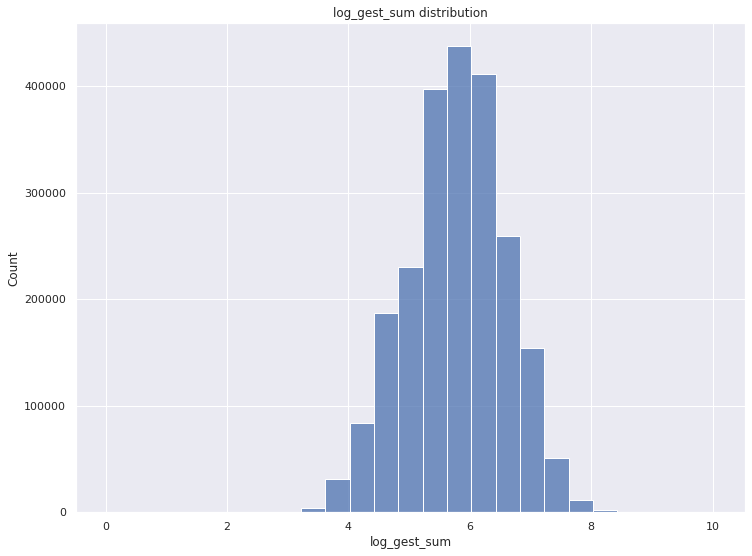

In [21]:
plt.figure(figsize=(12, 9))
sns.histplot(data['log_gest_sum'], bins=25) 
plt.title('log_gest_sum distribution')

Text(0.5, 1.0, 'log_gest_discount distribution')

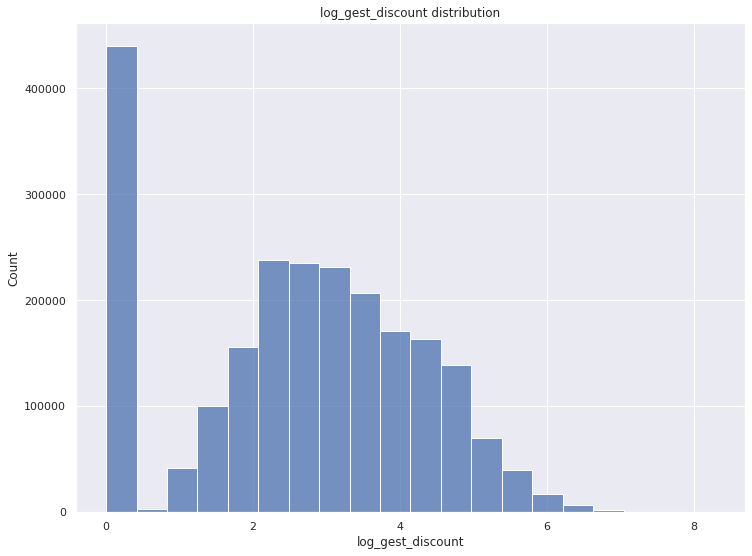

In [22]:
plt.figure(figsize=(12, 9))
sns.histplot(data['log_gest_discount'], bins=20) 
plt.title('log_gest_discount distribution')

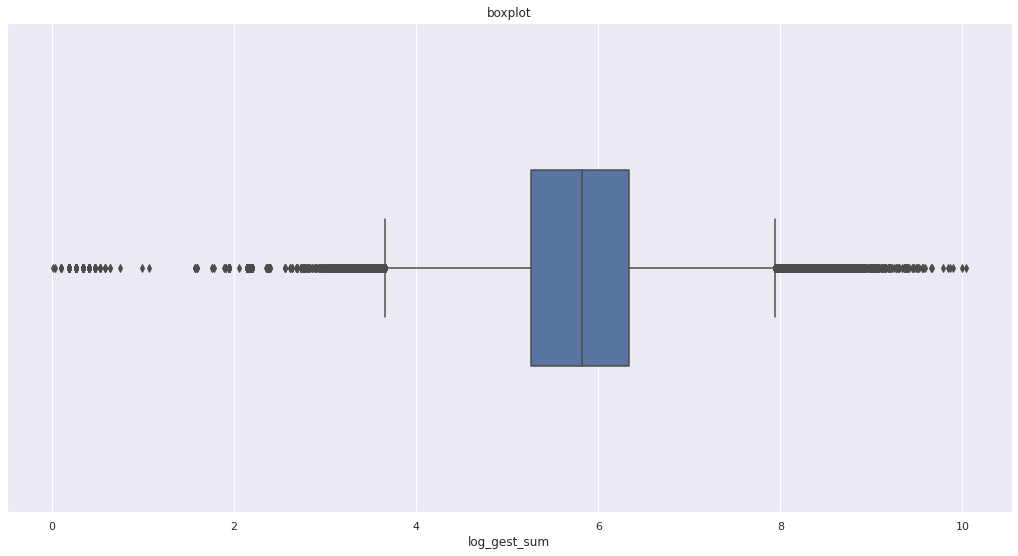

In [23]:
plt.figure(figsize=(18, 9))
plt.title('boxplot')
sns.boxplot(data['log_gest_sum'], width=0.4)

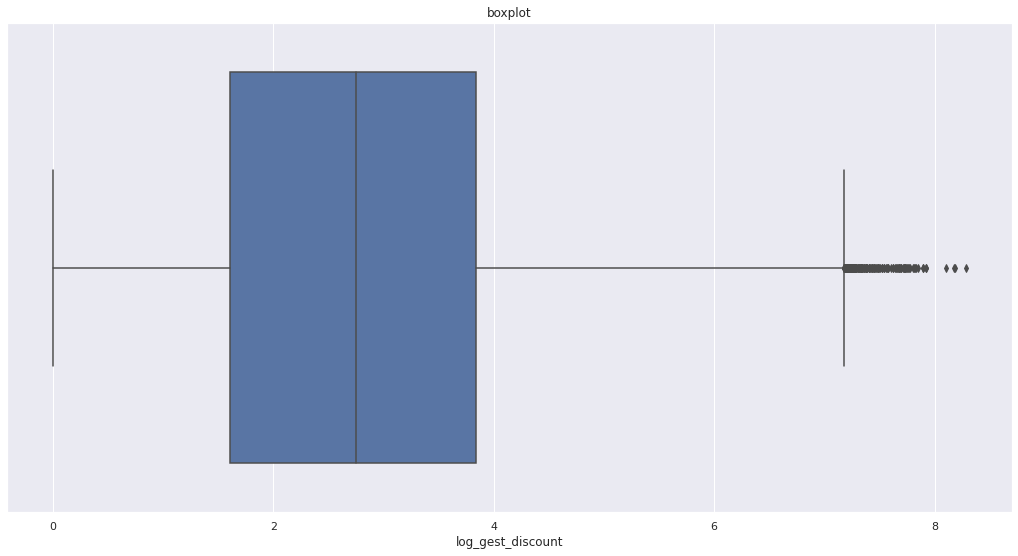

In [24]:
plt.figure(figsize=(18, 9))
plt.title('boxplot')
sns.boxplot(data['log_gest_discount'])

В колонках log_gest_sum и log_gest_discount присуствует очень много выбросов. Удалять все выбросы было бы ошибкой, удалим только те выбросы, у которых маленькая плотность.

In [25]:
data = data[(data['log_gest_sum'] > 2.5) & (data['log_gest_sum'] < 9.5) & (data['log_gest_discount'] < 8)]

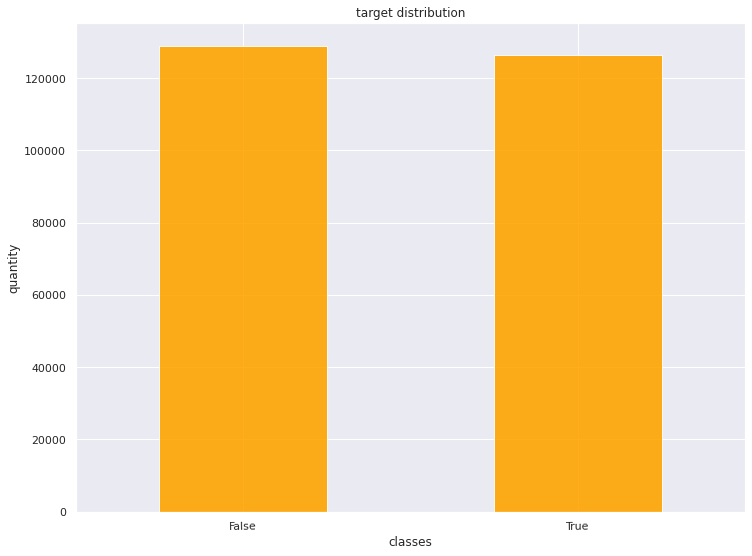

In [26]:
target['target'].value_counts().plot(kind='bar', title='target distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

В колонке target классы сбалансированы.

**Feature engeneering**

Приступим к генерации новых фичей. Реализовывать генерацию новых фичей будем с помощью функций, для того чтобы потом можно было просто агрегировать новые данные.

In [27]:
def min_and_max(df):
  '''adding new features: min_gest_sum, max_gest_sum'''
  df['min_check'] = df.groupby('client_id')['log_gest_sum'].transform('min')
  df['max_check'] = df.groupby('client_id')['log_gest_sum'].transform('max') 
  return df

In [28]:
def avg_check_and_discount(df):
    '''adding new features: avg_check and avg_discount'''
    new_features = df.pivot_table(index = 'client_id', values = ['log_gest_sum', 'log_gest_discount'], aggfunc = 'mean').reset_index()
    new_features.columns = ['client_id', 'avg_discount', 'avg_check']
    df = df.merge(new_features, on = 'client_id', how = 'left')
    return df

In [29]:
def avg_purchases_per_month(df):
    '''adding new feature: avg_purchases_per_month'''
    df['year_month'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str)
    df['total_months'] = df.groupby('client_id')['year_month'].transform('nunique')
    df['avg_purchases_per_month'] = df['total_purchases'] / df['total_months']
    df = df.drop(['year_month','total_months'], axis = 1)
    return df

In [30]:
def avg_days_between_purchases(df):
    '''adding new feature: avg_days_between_purchases'''
    delta_df = df.pivot_table(index = 'client_id', values = 'date', aggfunc = ['min', 'max']).reset_index()
    delta_df.columns = ['client_id', 'min_date', 'max_date']
    delta_df['delta'] = delta_df['max_date'] - delta_df['min_date']
    delta_df['delta'] = delta_df['delta'].dt.days
    delta_df = delta_df.drop(['min_date', 'max_date'], axis = 1)
    df = df.merge(delta_df, on = 'client_id', how = 'left')
    df['avg_days_between_purchases'] = df['delta'] / (df['total_purchases'] - 1)
    df['avg_days_between_purchases'] = df['avg_days_between_purchases']
    df = df.drop('delta', axis = 1)
    return df

In [31]:
def new_features(df):
    '''adding 6 new features: avg_check, avg_discount, avg_purchases_per_month, avg_days_between_purchases, min_check, max_check''' 
    df = avg_check_and_discount(df)
    df = avg_purchases_per_month(df)
    df = avg_days_between_purchases(df)
    df = min_and_max(df) 
    
    convert_dict = {'total_purchases': 'int32', 'avg_purchases_per_month': 'float32',
                    'avg_days_between_purchases': 'float32'}                
    df = df.astype(convert_dict)
    df = df.drop(['gest_sum', 'gest_discount', 'log_gest_sum', 'log_gest_discount', 'date'], axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    return df

In [32]:
data = new_features(data)

Итого было добавлено 7 фичей:
*   *avg_check* - средний чек.
*   *total_purchases* - суммарное кол-во покупок.
*   *avg_discount* - средняя скидка на покупку.
*   *avg_purchases_per_month* - среднее кол-во покупок в месяц.
*   *avg_days_between_purchases* - среднее кол-во дней между покупками.
*   *min_check* - минимальная сумма покупки.
*   *max_check* - максимальная сумма покупки.

In [33]:
data.head()

,client_id,target,total_purchases,avg_discount,avg_check,avg_purchases_per_month,avg_days_between_purchases,min_check,max_check
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,False,238,3.847804,5.698391,19.833334,1.464135,3.906005,8.067306
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,False,282,4.144737,5.203345,23.500000,1.234875,3.935740,7.250351
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,True,33,5.036721,6.183657,4.714286,6.031250,4.198705,7.400132
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,True,3,0.000000,6.306149,3.000000,3.500000,5.966147,6.587550
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,False,132,1.569789,4.859021,11.000000,2.625954,3.523415,6.678091


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149909 entries, 0 to 149908
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   149909 non-null  object 
 1   target                      149909 non-null  bool   
 2   total_purchases             149909 non-null  int32  
 3   avg_discount                149909 non-null  float32
 4   avg_check                   149909 non-null  float32
 5   avg_purchases_per_month     149909 non-null  float32
 6   avg_days_between_purchases  149909 non-null  float32
 7   min_check                   149909 non-null  float32
 8   max_check                   149909 non-null  float32
dtypes: bool(1), float32(6), int32(1), object(1)
memory usage: 5.3+ MB


Посмотрим на распределения новых фичей.

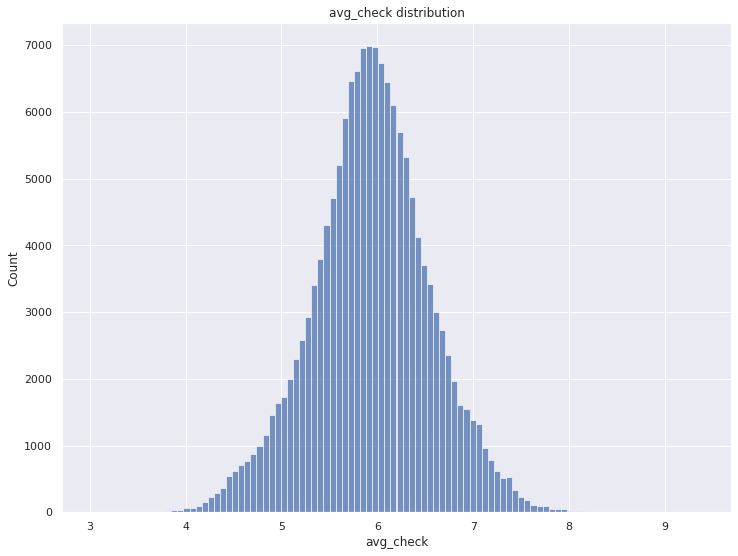

In [35]:
plt.figure(figsize=(12, 9))
plt.title('avg_check distribution')
sns.histplot(data['avg_check'], bins=100)

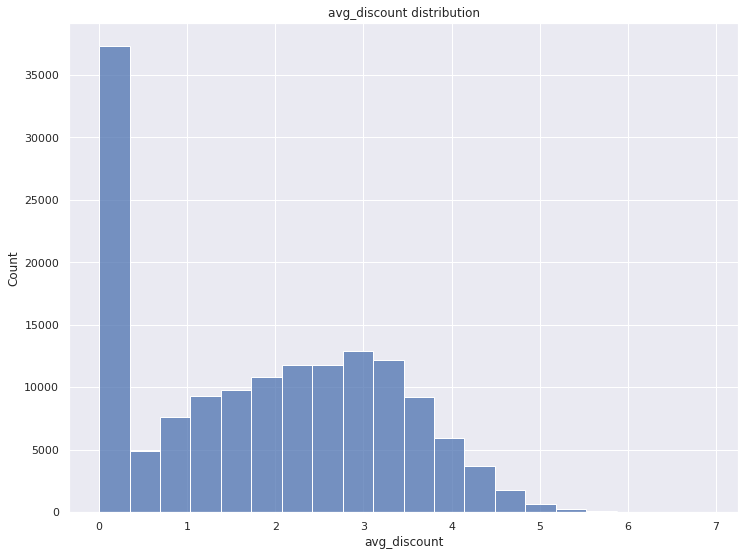

In [36]:
plt.figure(figsize=(12, 9))
plt.title('avg_discount distribution')
sns.histplot(data['avg_discount'], bins=20)

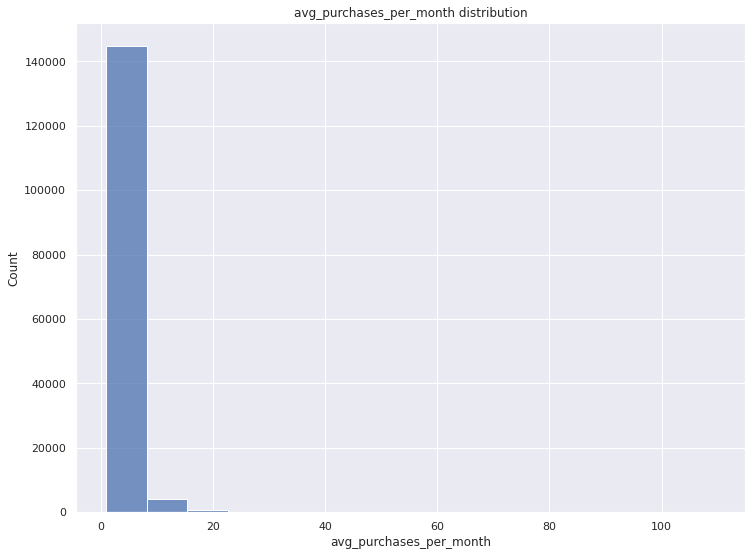

In [37]:
plt.figure(figsize=(12, 9))
plt.title('avg_purchases_per_month distribution')
sns.histplot(data['avg_purchases_per_month'], bins=15)

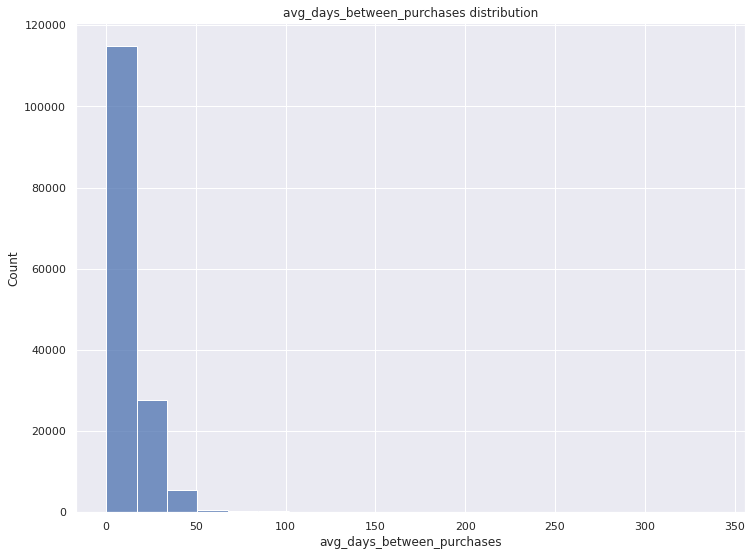

In [38]:
plt.figure(figsize=(12, 9))
plt.title('avg_days_between_purchases distribution')
sns.histplot(data['avg_days_between_purchases'], bins=20)

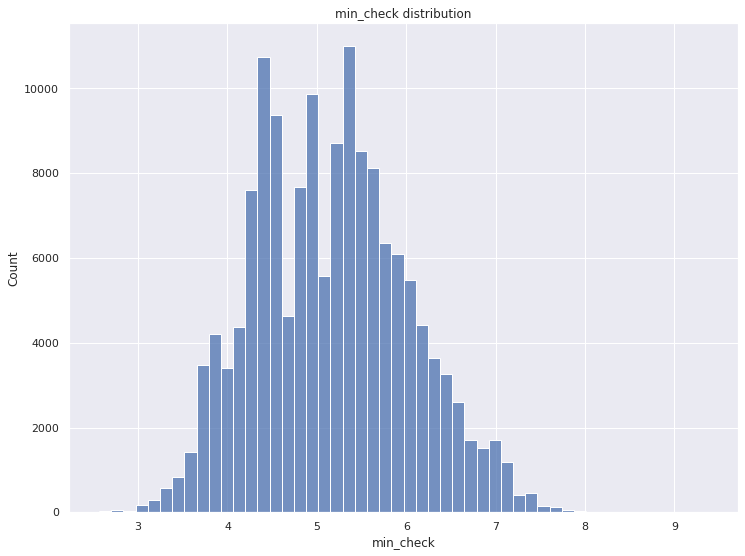

In [39]:
plt.figure(figsize=(12, 9))
plt.title('min_check distribution')
sns.histplot(data['min_check'], bins=50)

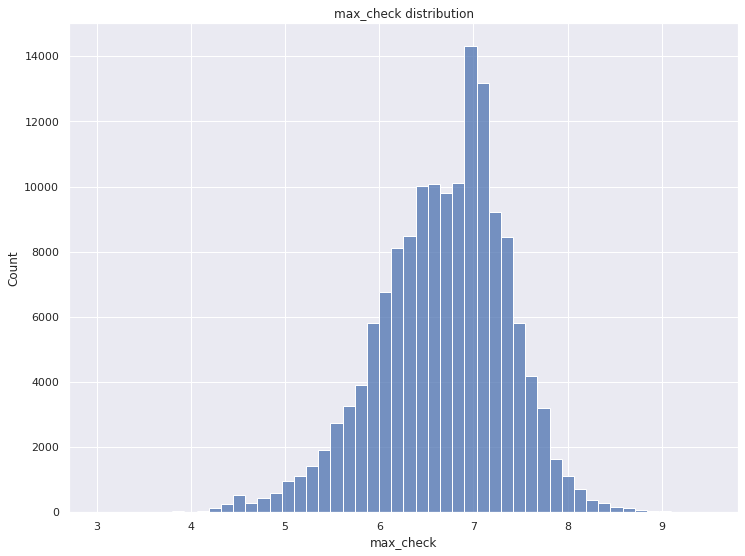

In [40]:
plt.figure(figsize=(12, 9))
plt.title('max_check distribution')
sns.histplot(data['max_check'], bins=50)

Посмотрим на корреляции.

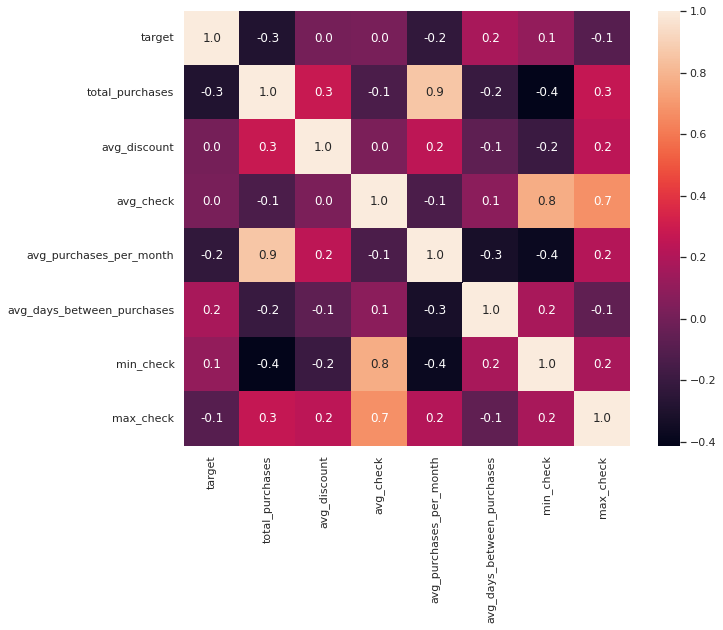

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".1f")

Заметно, что есть корреляция между фичами total_pruchases и avg_purchases_per_month, также есть значимая корелляция между фичей avg_check и фичами min_check и max_check. Нет сильных корреляций между фичами и таргетом, поэтому использовать линейные модели для этой задачи будет не лучшей идеей.

# **Baseline**

Для начала попробуем обучить случайный лес на двух фичах и посмотрим, какой скор выдаст моделька.

In [42]:
features = data.drop(['client_id', 'target'], axis = 1)
target = data['target']

Разделим датасет на две части - train и test.

In [43]:
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.9, random_state=67)

In [44]:
model = RandomForestClassifier(random_state=67)

В качестве метрики возьмем AUC-ROC

In [45]:
scores = cross_val_score(model, x_train, y_train, cv=3, scoring='roc_auc')
print(scores)
print('avg score:', scores.mean())

[0.7320804  0.73841756 0.73260824]
avg score: 0.7343687349361403


# **Modeling**

Протестируем различные модели: LogisticRegression, XGBClassifier и RandomForestClassifier.

In [46]:
models = {'Logistic Regression':LogisticRegression(max_iter=1000),
          'Random forest': RandomForestClassifier(random_state=67),
          'Xgboost': XGBClassifier(random_state=67, tree_method='gpu_hist')
         }

In [47]:
for model_name, current_model in models.items():
    model = current_model
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
    print(model_name,':', scores.mean(), '(avg)')

Logistic Regression : 0.7027278500744385 (avg)
Random forest : 0.7353272940452888 (avg)
Xgboost : 0.7479135927880594 (avg)


Xgboost показал  себя лучше остальных, поэтому возьмем его в качестве основной модели и приступим к подбору гиперпараметров.

**Hyperparameter tuning**

In [48]:
model = XGBClassifier(tree_method='gpu_hist', random_state=67)

In [49]:
xgb_params = {
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'max_depth': np.arange(5, 16, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),
    'subsample': [0.8, 1],
    'n_estimators': np.arange(100, 500, 25)
}

In [50]:
rs_model = RandomizedSearchCV(model, 
                              param_distributions=xgb_params, 
                              scoring='roc_auc', 
                              random_state=67,
                              n_iter=50,
                              n_jobs=-1,
                              verbose=3, 
                              cv=3
                             )
rs_model.fit(x_train, y_train)
rs_model.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 225,
 'subsample': 0.8}

In [51]:
model = rs_model.best_estimator_
model.fit(x_train, y_train)

XGBClassifier(colsample_bytree=0.6000000000000001, learning_rate=0.05,
              max_depth=8, n_estimators=225, random_state=67, subsample=0.8,
              tree_method='gpu_hist')

Теперь проверим модель на тестовой выборке.

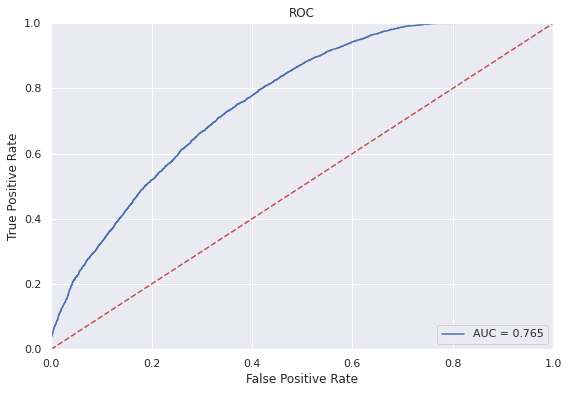

In [52]:
probs = model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Results**

Теперь приступим к анализу нашей модели. Для этого воcпользуемся библиотекой shap.

In [53]:
x_train_and_test = pd.concat([x_train, x_test])
y_train_and_test = pd.concat([y_train, y_test])

In [54]:
model = XGBClassifier(colsample_bytree=0.6, 
                      learning_rate=0.05,
                      n_estimators=225,  
                      random_state=67,
                      subsample=0.8,
                      max_depth=8
                     )
model.fit(x_train_and_test, y_train_and_test)

XGBClassifier(colsample_bytree=0.6, learning_rate=0.05, max_depth=8,
              n_estimators=225, random_state=67, subsample=0.8)

In [55]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_and_test)

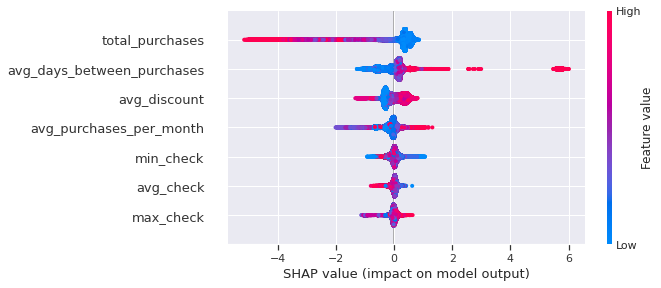

In [56]:
shap.summary_plot(shap_values, x_train_and_test)

Из данного графика видно, что при высоких значениях фичей total_purchases, avg_check модель склоняется к тому, что клиент не уйдет в отток, а при низких значениях фичей total_purchases, min_check и при высоких значениях avg_days_between_purchases, avg_purchases_per_month модель склоняется к тому, что клиент уйдет в отток.

Теперь посмотрим на значимость фичей.

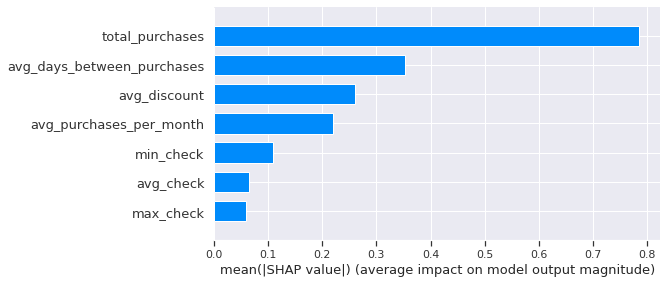

In [57]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

По графику видно что топ-3 самых значимых параметра для модели: суммарное кол-во покупок, среднее кол-во дней между покупками и средняя скидка.

# **Conclusion**

**Была проделана огромная работа. Данные были изучены и предобработаны, был проведен исследовательский анализ данных, были написаны функции для удобной генерации новых фичей, были протестированы различные модели и у основной модели был произведен подбор гиперпараметров. Также после обучения модели была произведеен анализ обученной модели: было изучено влияние значений фичей на предсказания модели, а также были изучены фичи, которые сильнее всего влияли на предсказания модели. Если бы были данные о самом покупателе и о позициях в чеке, то тогда результат модели был бы выше, но даже при минимальном наборе информации (дата покупки, сумма покупки, сумма скидки) удалось достичь результата в 0.765 по метрике AUC-ROC. Внедрение данной подели в продакшн позволит компании снизить отток и тем самым увеличить доход.**